<a href="https://colab.research.google.com/github/Amirhk-dev/MNIST-Lab/blob/main/experiments/notebooks/Visualization_and_Projection/MNIST_Lab_Dataset_Visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MNIST Dataset Visualization

In this notebook, the images in the MNIST dataset are shown as well as the projection of the images in the trainset to 2 dimensional coordinates.

## MNIST Dataset Information

Dataset contains $28 \times 28$ resolution images. Images show the values between 0 and 9. The pixel values range between 0 to 1.

## Load all the relevant libaries

In [1]:
import torch
import torchvision.transforms as transforms
from torchvision import datasets
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
!pip install umap-learn
import umap
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd
import seaborn as sns
import random

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 KB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 17.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82829 sha256=ddda08f34949fd87dda8506a47e5ac66776d7ff78be67919f455ec268d83b0ee
  Stored in directory: /root/.cache/pip/wheels/a9/3a/67/06a8950e053725912e6a8c42c4a3a241410f6487b8402542ea
  Created wheel for pynndescent: filename=pynndescent-0.5.8-py3-none-any.whl size=55513 sha256=9eed0744b7790488ced77fb7a91b5c212f5518f6869c7cb56daed1002fa422d3
  Stored in directory: /root/.cache/pip/wheels/1c/63/3a/29954bca1a27ba100ed8c27973a78cb71b43dc67aed62e80c3
Successfully built umap-learn pynndescent


## Check if there is a GPU device or not:

In [2]:
gpu_availability = torch.cuda.is_available()
print(f"Is the GPU available? {gpu_availability}")

Is the GPU available? False


In [3]:
device = torch.device("cuda") if gpu_availability else torch.device("cpu")
print(f"The using device is: {device}")

The using device is: cpu


## Make the processes deterministic and reproducible

In [4]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
seed = 42 # 101010
set_seed(seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

In [12]:
input_size = 28*28

### Load the data and transform it to run through the network

In [13]:
train_transform = transforms.Compose([transforms.ToTensor()])
test_transform = transforms.Compose([transforms.ToTensor()])

train_dataset = datasets.MNIST('datasets/MNIST',
                               transform=train_transform,
                               download=True,
                               train=True)

test_dataset = datasets.MNIST('datasets/MNIST',
                               transform=test_transform,
                               download=True,
                               train=False)

train_set, val_set = torch.utils.data.random_split(train_dataset,
                                                   [50000, 10000])

## Display some images from the trainset

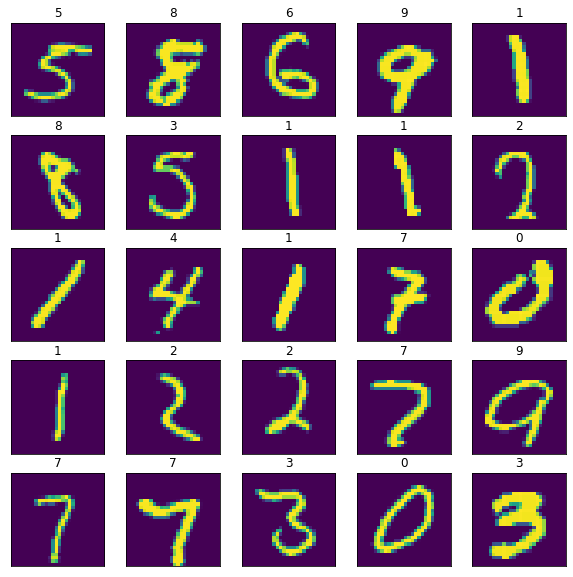

In [8]:
class_names = {0:'0', 1:'1', 2:'2', 3:'3', 4:'4', 
               5:'5', 6:'6', 7:'7', 8:'8', 9:'9'}
plt.figure(figsize=(10, 10))
counter = 0
for idx in range(25):
  plt.subplot(5, 5, counter+1)
  counter += 1
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(train_set[idx][0].reshape((28,28)))
  label_index = int(train_set[idx][1])
  plt.title(class_names[label_index])
plt.show()
plt.close()

In [11]:
X_train = train_dataset.data.numpy().astype('float32')
Y_train = train_dataset.targets.numpy()
X_test = test_dataset.data.numpy().astype('float32')
Y_test = test_dataset.targets.numpy()
X_train, X_val, Y_train, Y_val = train_test_split(X_train,
                                                  Y_train, 
                                                  test_size=0.1, 
                                                  random_state=seed)
X_train /= 255.0
X_val /= 255.0
X_test /= 255.0
X_train = X_train.reshape(X_train.shape[0], input_size)
X_val = X_val.reshape(X_val.shape[0], input_size)
X_test = X_test.reshape(X_test.shape[0], input_size)
print(f"The shape of the train set images is: {X_train.shape}")
print(f"The shape of the val set images is: {X_val.shape}")
print(f"The shape of the test set images is: {X_test.shape}")

The shape of the train set images is: (54000, 784)
The shape of the val set images is: (6000, 784)
The shape of the test set images is: (10000, 784)


## Bring the data from high dimension ($28 \times 28=784$) to a 2 dimensions for visualization

One dimensionality reduction method is **PCA** (Principal Component Analysis). There are other approaches such as
**t-SNE** (t-distributed Stochastic Neighbour Embedding) and **UMAP** (Uniform Manifold Approximation and Projection).
Here, we try PCA, t-SNE, and UMAP to see their effect on the MNIST dataset.

**t-SNE** try to keep neighborhood points as close as possible and non-neighborhood points as far away from each other as possible, but it does not preserve the distance between cluster while projecting in low dimension space.

### 1. UMAP (projecting to 2 dimensions)

/usr/local/lib/python3.8/dist-packages/seaborn/axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


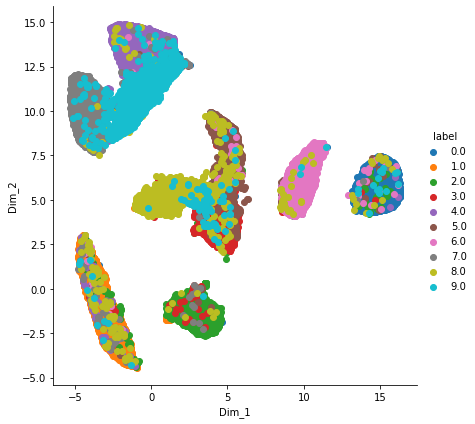

In [ ]:
umap_2_dim = umap.UMAP(n_components = 2, random_state = seed)
X_train_umap_2_dim = umap_2_dim.fit_transform(X_train)
umap_data = np.vstack((X_train_umap_2_dim.T, Y_train)).T
umap_df = pd.DataFrame(data = umap_data, columns=("Dim_1", "Dim_2", "label"))
sns.FacetGrid(umap_df, hue="label", size=6).map(plt.scatter,
                                                'Dim_1',
                                                'Dim_2').add_legend()
plt.show()

### 2. tSNE (projecting to 2 dimensions)

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


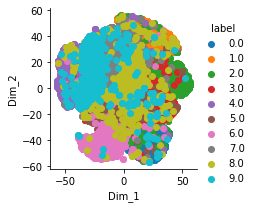

In [ ]:
tsne_2_dim = TSNE(n_components=2, random_state=seed)
tsne_data = tsne_2_dim.fit_transform(X_train)
tsne_data = np.vstack((tsne_data.T, Y_train)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))
sns.FacetGrid(tsne_df, hue="label").map(plt.scatter,
                                                'Dim_1',
                                                'Dim_2').add_legend()
plt.show()

### 3. PCA (projecting to 2 dimensions)

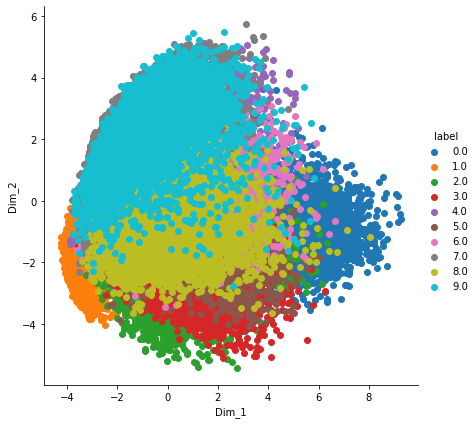

In [ ]:
pca_2_dim = PCA(n_components = 2, random_state = seed)
X_train_pca_2_dim = pca_2_dim.fit_transform(X_train)
pca_data = np.vstack((X_train_pca_2_dim.T, Y_train)).T
pca_df = pd.DataFrame(data = pca_data, columns=("Dim_1", "Dim_2", "label"))
sns.FacetGrid(pca_df, hue="label", height=6).map(plt.scatter, 
                                               'Dim_1',
                                               'Dim_2').add_legend()
plt.show()